In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
train_csv = 'data/sunspot_train.csv'
test_csv = 'data/sunspot_test.csv'

In [4]:
train_df = pd.read_csv(train_csv, index_col=0)
test_df = pd.read_csv(test_csv, index_col=0)

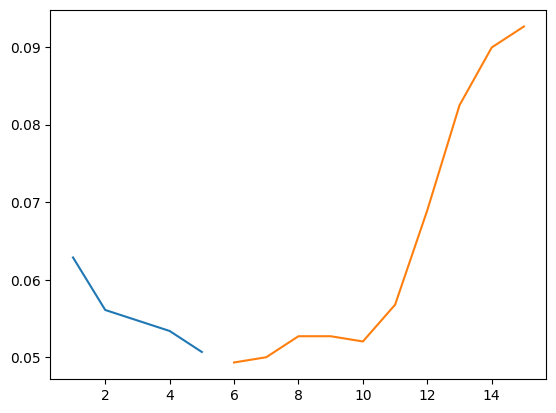

In [5]:
fig, ax = plt.subplots()

ts_input = np.array(range(1, 6))
X_train = train_df.loc[:, [f'Input{i}' for i in ts_input]].values
X_test = test_df.loc[:, [f'Input{i}' for i in ts_input]].values

ts_output = np.array(range(1, 11))
y_train = train_df.loc[:, [f'Output{i}' for i in ts_output]].values
y_test = test_df.loc[:, [f'Output{i}' for i in ts_output]].values

ts_output = ts_output + ts_input[-1]

ax.plot(ts_input, X_train[0])
ax.plot(ts_output, y_train[0])

In [6]:
def tilted_loss(q, y, f):
    e = (y-f)
    return torch.mean(torch.max(q*e, (q-1)*e))

In [20]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)

quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
quantile_loss = np.zeros(len(quantiles))

input_size = 5
hidden_size = 256
out_ts = 10
output_size = out_ts*len(quantiles)

lr = 1e-2
num_epochs = 5000

model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Linear(hidden_size, output_size)
        ).double()

opt = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
quantile_loss = np.zeros(len(quantiles))

# Training loop
for epoch in range(num_epochs):

    # for j, (q, model, opt) in enumerate(zip(quantiles, models, opts)):

    model = model.train()

    # Zero the parameter gradients
    opt.zero_grad()

    # Forward pass
    y_pred = model(X_train_tensor)

    # Calculate loss
    loss = 0.0 
    for j, q in enumerate(quantiles):
        qloss = tilted_loss(q, y_train_tensor, y_pred[:, j*out_ts:min((j+1)*out_ts, output_size)])
        loss += qloss
        quantile_loss[j] = qloss.item()

    # Backward pass and optimization
    loss.backward()
    opt.step()
    
    # Print statistics
    print(f'[{epoch + 1}] loss: {quantile_loss}')
    # print('[%d] loss: %.3f' %
    #         (epoch + 1, running_loss))

print('Finished Training')

[1] loss: [0.03074996 0.09731281 0.1721104  0.33936917 0.41405553]
[2] loss: [0.11819182 0.21447005 0.18525156 0.09097609 0.03509146]
[3] loss: [0.03292494 0.06909432 0.1521358  0.15139478 0.03746694]
[4] loss: [0.03608263 0.084369   0.08071542 0.16519034 0.05042075]
[5] loss: [0.05472988 0.10695372 0.09913855 0.14327339 0.05731482]
[6] loss: [0.04153644 0.10587283 0.1093937  0.10811241 0.06029457]
[7] loss: [0.04253909 0.09098884 0.0733116  0.09079224 0.06060073]
[8] loss: [0.04124421 0.07341347 0.06350998 0.08309315 0.05917592]
[9] loss: [0.04176751 0.05878192 0.07347073 0.07092088 0.05643185]
[10] loss: [0.04077237 0.05755046 0.07800755 0.06160448 0.05259393]
[11] loss: [0.03923437 0.055431   0.06637218 0.06282728 0.04810758]
[12] loss: [0.03784396 0.0484261  0.05347413 0.06487841 0.04336833]
[13] loss: [0.03505967 0.04330285 0.05496981 0.05957922 0.04057148]
[14] loss: [0.03232563 0.04264364 0.05929679 0.05388271 0.04048595]
[15] loss: [0.03068254 0.0472494  0.05499411 0.05355724 0

In [22]:
y_pred_list = []
test_quantile_loss = np.zeros(len(quantiles))

X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

model = model.eval()
y_pred = model(X_test_tensor).reshape(-1, len(quantiles), out_ts)

for j, q in enumerate(quantiles):
    test_quantile_loss[j] = tilted_loss(q, y_test_tensor, y_pred[:, j])

y_pred = y_pred.detach().numpy()

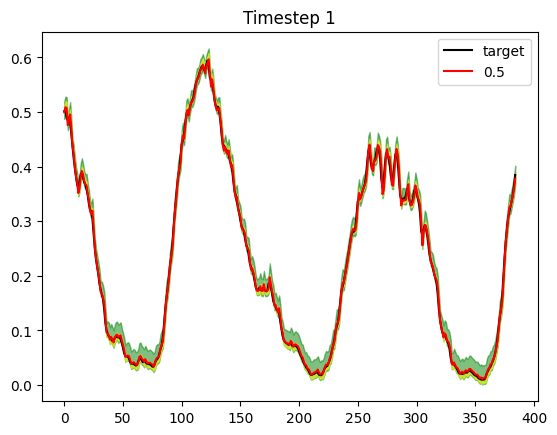

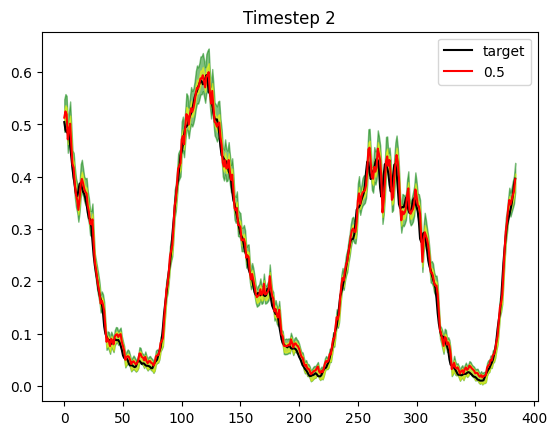

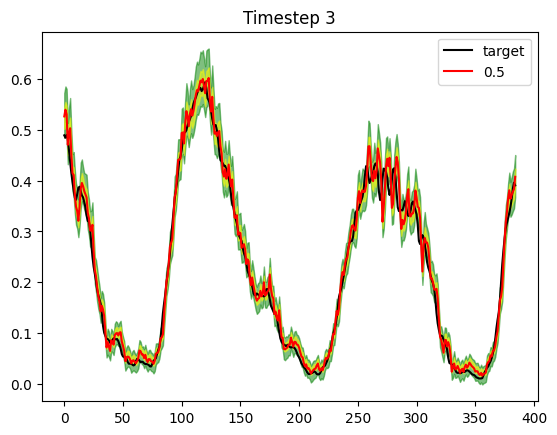

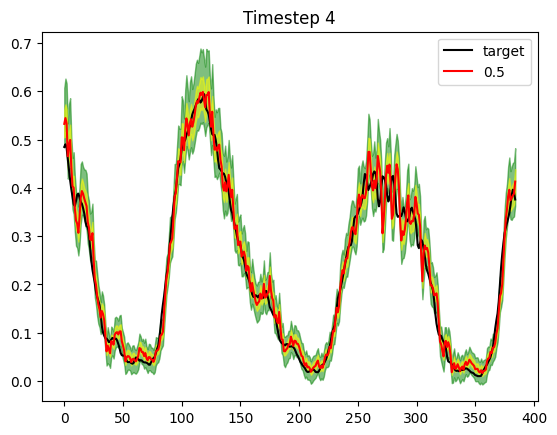

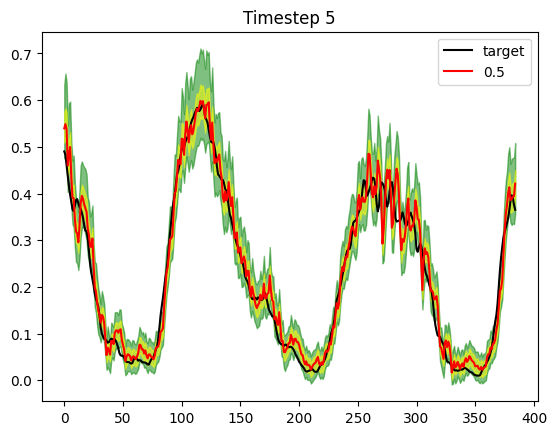

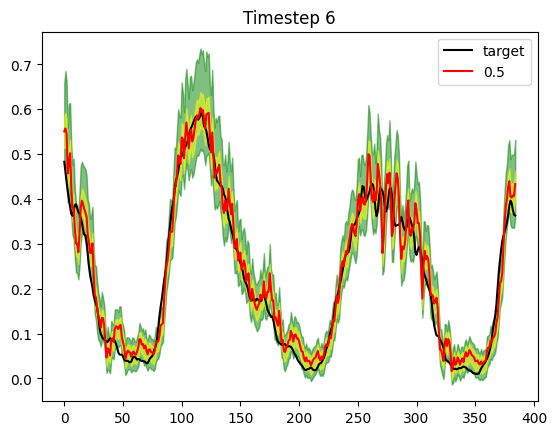

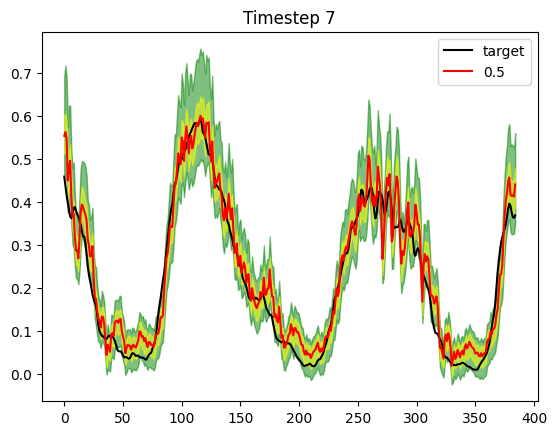

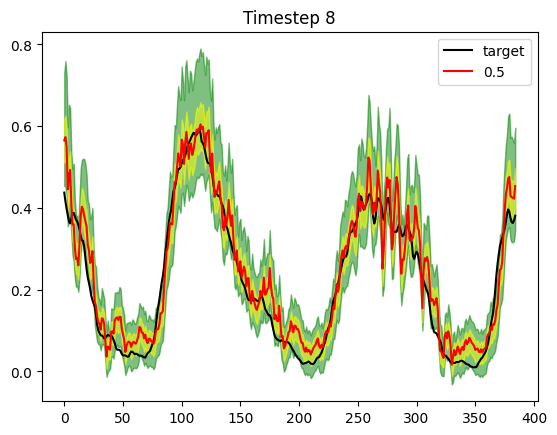

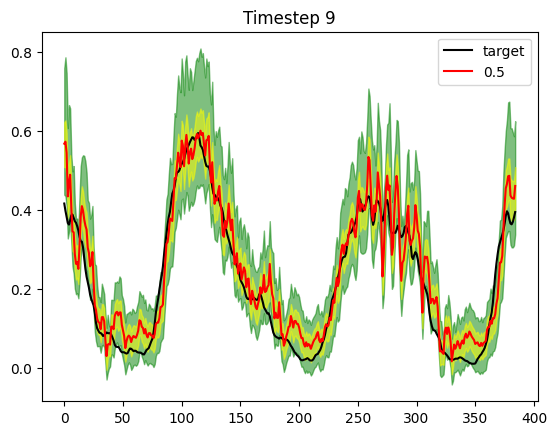

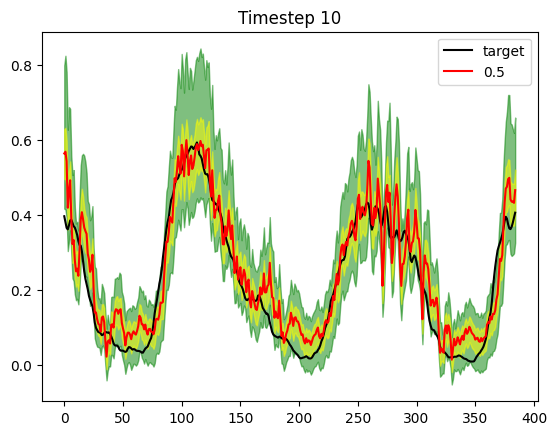

In [23]:
colors = ['green', 'orange', 'red', 'orange', 'green']

for ts in range(10):
    
    fig, ax = plt.subplots()
    ax.plot(y_test[:, ts], color='black', label='target')
    
    # for i, q in enumerate(quantiles):
    ax.plot(y_pred[:, 2, ts], color=colors[2], label=0.5)
    ax.fill_between(range(len(y_pred)),  y_pred[:, 0, ts], y_pred[:, -1, ts], alpha=0.5, color='green')
    ax.fill_between(range(len(y_pred)),  y_pred[:, 1, ts], y_pred[:, -2, ts], alpha=0.5, color='yellow')

    ax.set_title(f'Timestep {ts+1}')
    plt.legend()

In [24]:
test_quantile_loss

array([0.00314955, 0.0104551 , 0.01421782, 0.01184601, 0.00436363])